In [1]:
# libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for A/B testing
from scipy import stats as st
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy.stats import ttest_ind, f_oneway, kruskal, levene
from statsmodels.stats.multicomp import MultiComparison

import warnings
warnings.filterwarnings("ignore")

# Dataset 1

## Выгрузка и первоначальное исследование данных

In [2]:
# Загрузка датасета
df_1 = pd.read_csv('..\\data\\heart.csv', delimiter=',')
df_1.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df_1.shape # Размерность

(303, 14)

Описание первого датасета:

В первом датафрейме имеется всего 14 столбцов и 303 наблюдения, что не так много для дальнейшего построения модели. Однако всё равно стоит учитывать данный набор данных для дальнейшего построения моделей по ансамблевой системе. Также по результатам исследования данного набора данных будет принято решение о вероятном искусственном увеличении его сэмплов.

Краткое описание столбцов:

* age - возраст
* sex - пол
* cp (chest pain type) - тип боли в груди
* trestbps (resting blood pressure) - артериальное давление в состоянии покоя
* chol - уровень холистерина
* fbs - повышенный сахар в крови (fasting blood sugar)
* restecg - результаты электрокардиографии в состоянии покоя
* thalach - максимальное сердцебиение в состоянии активности
* exang - боли в груди во время упражнений
* oldpeak - дельта снижения сердцебиения от активности в покой (ST на кардиограмме)
* slope - наклон пиковой нагрузки сегмента ST (также показатель на кардиограмме)
* ca - также один из показателей пиков на кардиограмме (импульс от CA-узла к предсердиям и желудочкам)
* thal - четвёртый показатель на кардиограмме
* target - целевая переменная, которая означает есть ли у человека патологические проблемы с сердечно-сосудистой системой

In [4]:
# Пропуски
df_1.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Пропусков в датафрейме нет, что неудивительно для такого малого количества сэмплов.

In [5]:
# Проверка на наличие явных дубликатов
df_1.duplicated().sum()

np.int64(1)

In [6]:
df_1[df_1.duplicated() == True]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


В датасете находится один явный дубликат. Однако в виду малого количества записей, а также достаточно типичных признаков, которые нельзя назвать индивидуальными, следовательно, его нельзя признать явным дубликатом.

Также в целом не имеет статистической значимости оставлять данный набор данных или его удалить в виду относительно незначительного соотношения к общей размерности датасета.

In [7]:
# Описательная статистика
df_1.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


В датасете явно присутствуют категориальные признаки и флаги. Выделим их:

In [8]:
list(df_1.columns)

['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal',
 'target']

In [9]:
df_1.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

In [10]:
# Оставим только категориальные признаки
for col in df_1.columns:
    if df_1[col].nunique() < 20:
        print(f"{col}: {df_1[col].unique()}")

sex: [1 0]
cp: [3 2 1 0]
fbs: [1 0]
restecg: [0 1 2]
exang: [0 1]
slope: [0 2 1]
ca: [0 2 1 3 4]
thal: [1 2 3 0]
target: [1 0]


In [11]:
for col in df_1.columns:
    if df_1[col].nunique() > 20:
        print(col)

age
trestbps
chol
thalach
oldpeak


1. В столбце пол верно предсказаны уникальные значения (1 - мужчина, 0 - женщина);
2. Также представлены 3 вида типов боли в груди по возрастанию (0 - боли в груди нет, 3 - сильная боль в груди);
3. Переменная повышенного сахара в крови является просто флагом (да - нет);
4. Боли в груди во время упражнений также являются флагами;
5. Все переменные, относящиеся к кардиографическому исследованию сердца, имеют различные уникальные значения. В связи с этим в виду отсутствия конкретной информации об их назначении требуется уточнение смысла на момент моделирования либо дополнительное исследование для выдвижения гипотез о назначении лейблов в данных столбцах. На текущий момент исследования данных пока что не имеет смысла от них избавляться.

## Графическое изучение структуры данных

In [12]:
# категориальные и числовые столбцы
cat_feat = [
                'sex',
                'cp',
                'fbs',
                'restecg',
                'exang',
                'slope',
                'ca',
                'thal'
            ]
num_feat = [
                'age',
                'trestbps',
                'chol',
                'thalach',
                'oldpeak'
            ]

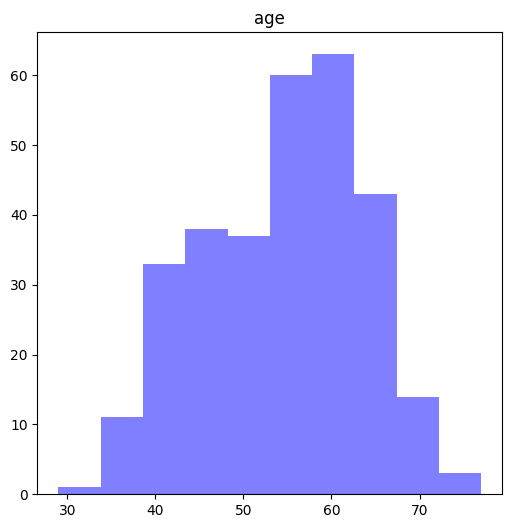

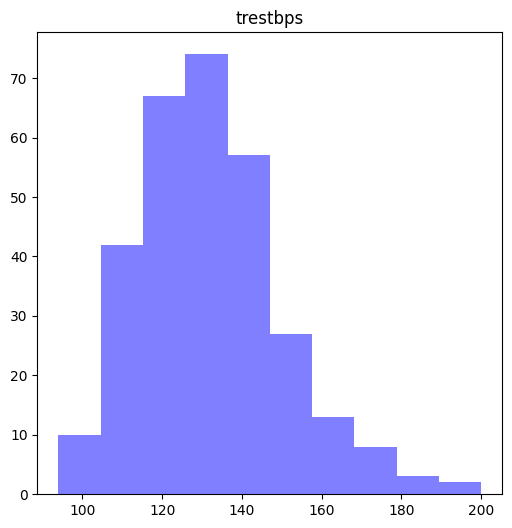

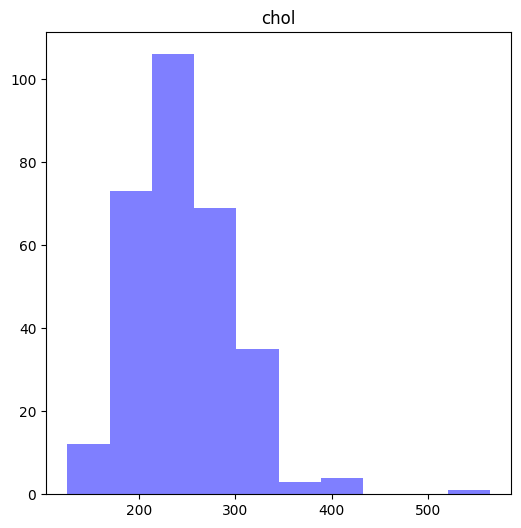

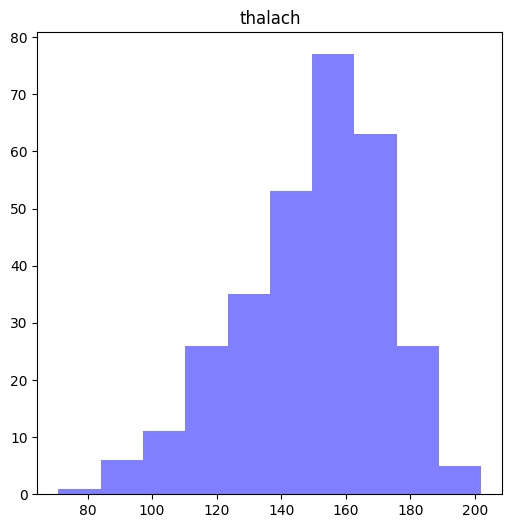

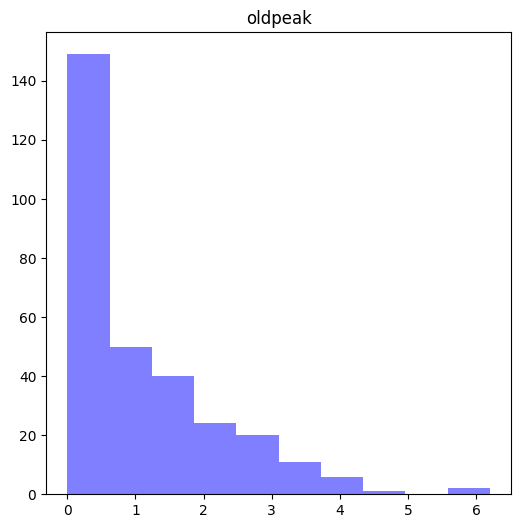

In [13]:
# Распределения числовых столбцов
for col in num_feat:
    plt.figure(figsize=(6,6))
    plt.hist(x=col, data=df_1, color='b', alpha = 0.5)
    plt.title(col)

1. Возраст обследуемых распределён близко к нормальному со смещением матожидания вправо примерно на уровне 58-60 лет;
2. Артериальное (верхнее давление) в состоянии покоя также имеет распределение, близкое к нормальному с матожиданием, близким к нормальному верхнему давлению человека (120 мм рт. с.) с увеличенным правым хвостом, что логично, тк с артериальным давлением, ниже 90-95 мм рт. с. невозможно вести нормальную жизнь, однако в пожилом возрасте часто встречается достаточно высокое давление;
3. Уровень холестерина также имеет распределение, близкое к нормальному, с аномальным значением в районе 560 единиц (ммоль/литр). В целом, для улучшения качество построения базовых моделей имеет смысл привести данное аномальное значение к остальному нормальному распределению (буквально подогнать под остальные данные). Также существуют и другие способы устранения аномальных значений (особенно для такого незначительного их числа). При этом стоит учитывать, что несмотря на то, что данные значения являются фактическими визуальными выбросами, их замена означает подмену реальных показателей исследуемого в рамках всей выборки и в случае их приведения данный факт стоит учитывать и на отложенной выборке;
4. Максимальное сердцебиение в состоянии активности также имеет распределение, близкое к нормальному с увеличенным левым хвостом. Вероятно, в нём содержатся люди с исходно заниженным сердцебиением и давлением;
5. Переменная разности снижения сердцебиения от состояния активности до состояния покоя (в минутах) в отличие от остальных имеет логнормальное распределение, что также логично, поскольку в норме у здоровых людей ритм сердца приходит в норму до одной минуты после прекращения активности, большее количество времени, очевидно, встречается у всё более тяжелобольных обследуемых. Также имеется выброс в районе дельты в 6 минут.

В целом, все переменные имеют нормальное распредление (или его половину), даже несмотря на центральную предельную теорему и сравнительно малую выборку обследуемых.

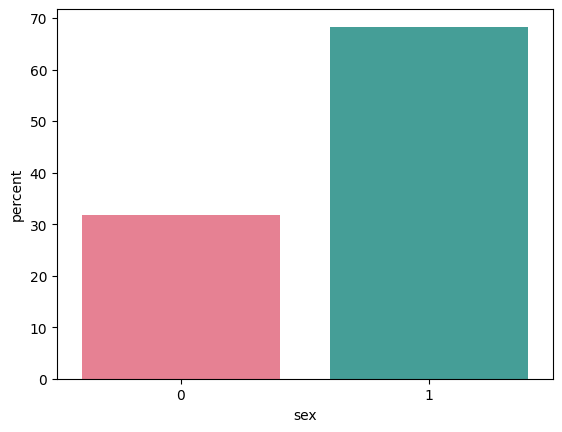

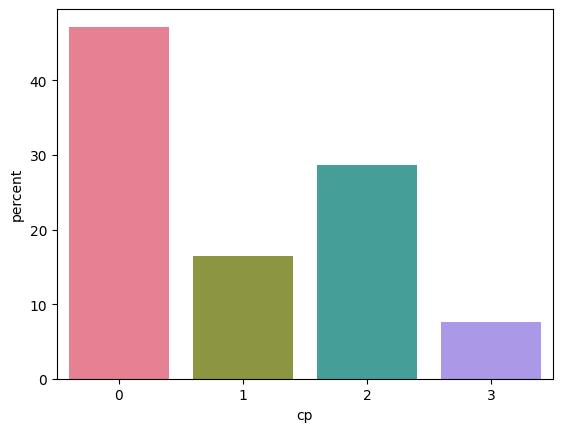

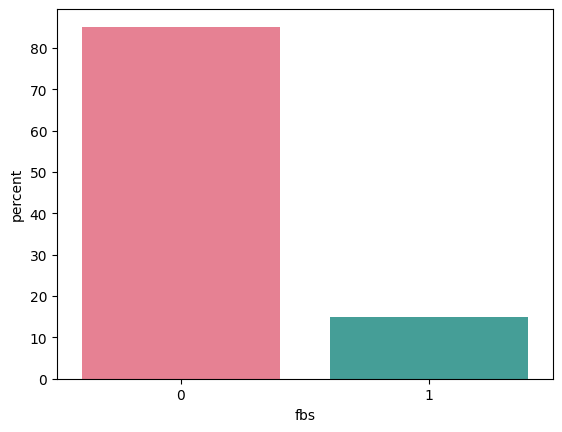

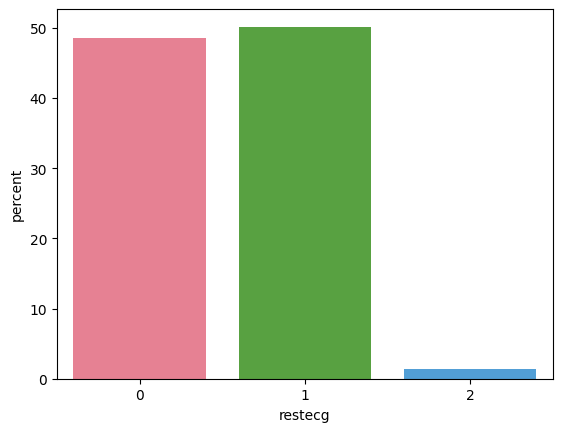

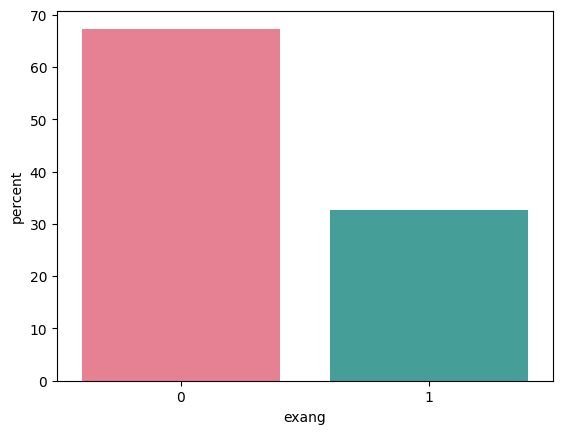

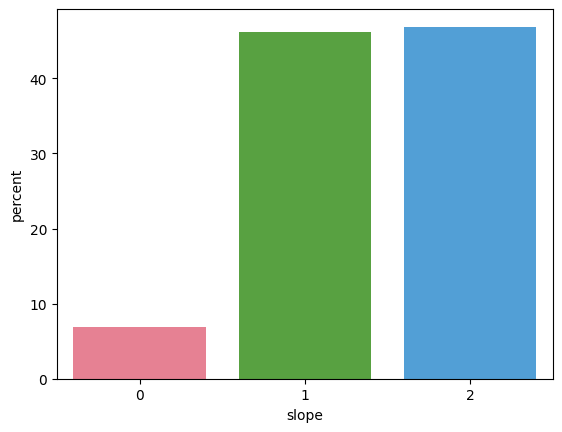

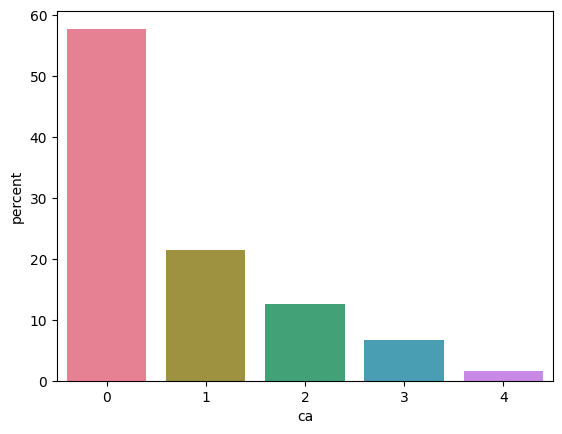

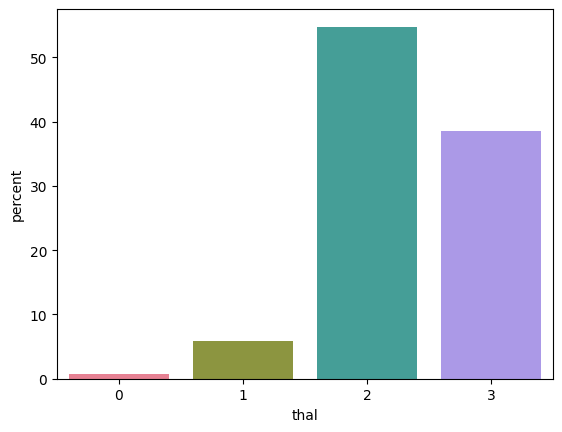

In [14]:
# Категориальные столбцы
for col in df_1[cat_feat]:
    sns.countplot(df_1, x=col, stat='percent', palette='husl')
    plt.show()

Среди категориальных переменных присутствуют классы как достаточно равнонаполненные и значительные по количеству, так и незначительные сравнительно всей выборки. Возможно на этапе подготовки данных имеет смысл объединить некоторые классы, наименьшие по частоте (например, для результатов кардиографии в состоянии покоя объединить классы 1 и 2 по смыслу "есть отклонения", это касается и других категориальных переменных по смыслу).

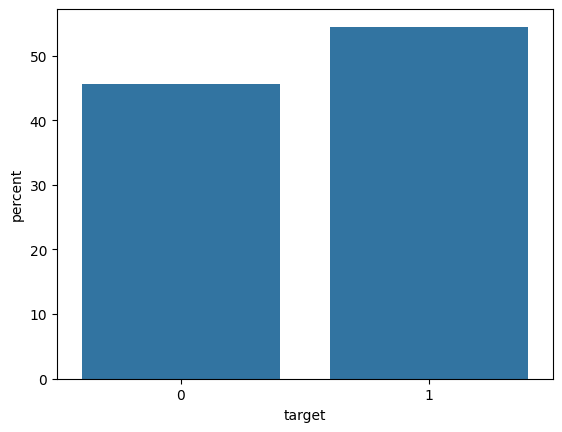

In [15]:
# Соотношение таргетов
sns.countplot(df_1, x='target', stat='percent')
plt.show()

Таргеты в данной выборке имеют соотношение, близкое к равному. Возможно при подготовке данных имеет смысл увеличить соотношение нулей к единицам методов апсэмплинга, что позволит немного увеличить выборку, а также улучшить качество моделей.

In [18]:
df_1.shape

(303, 14)

[]

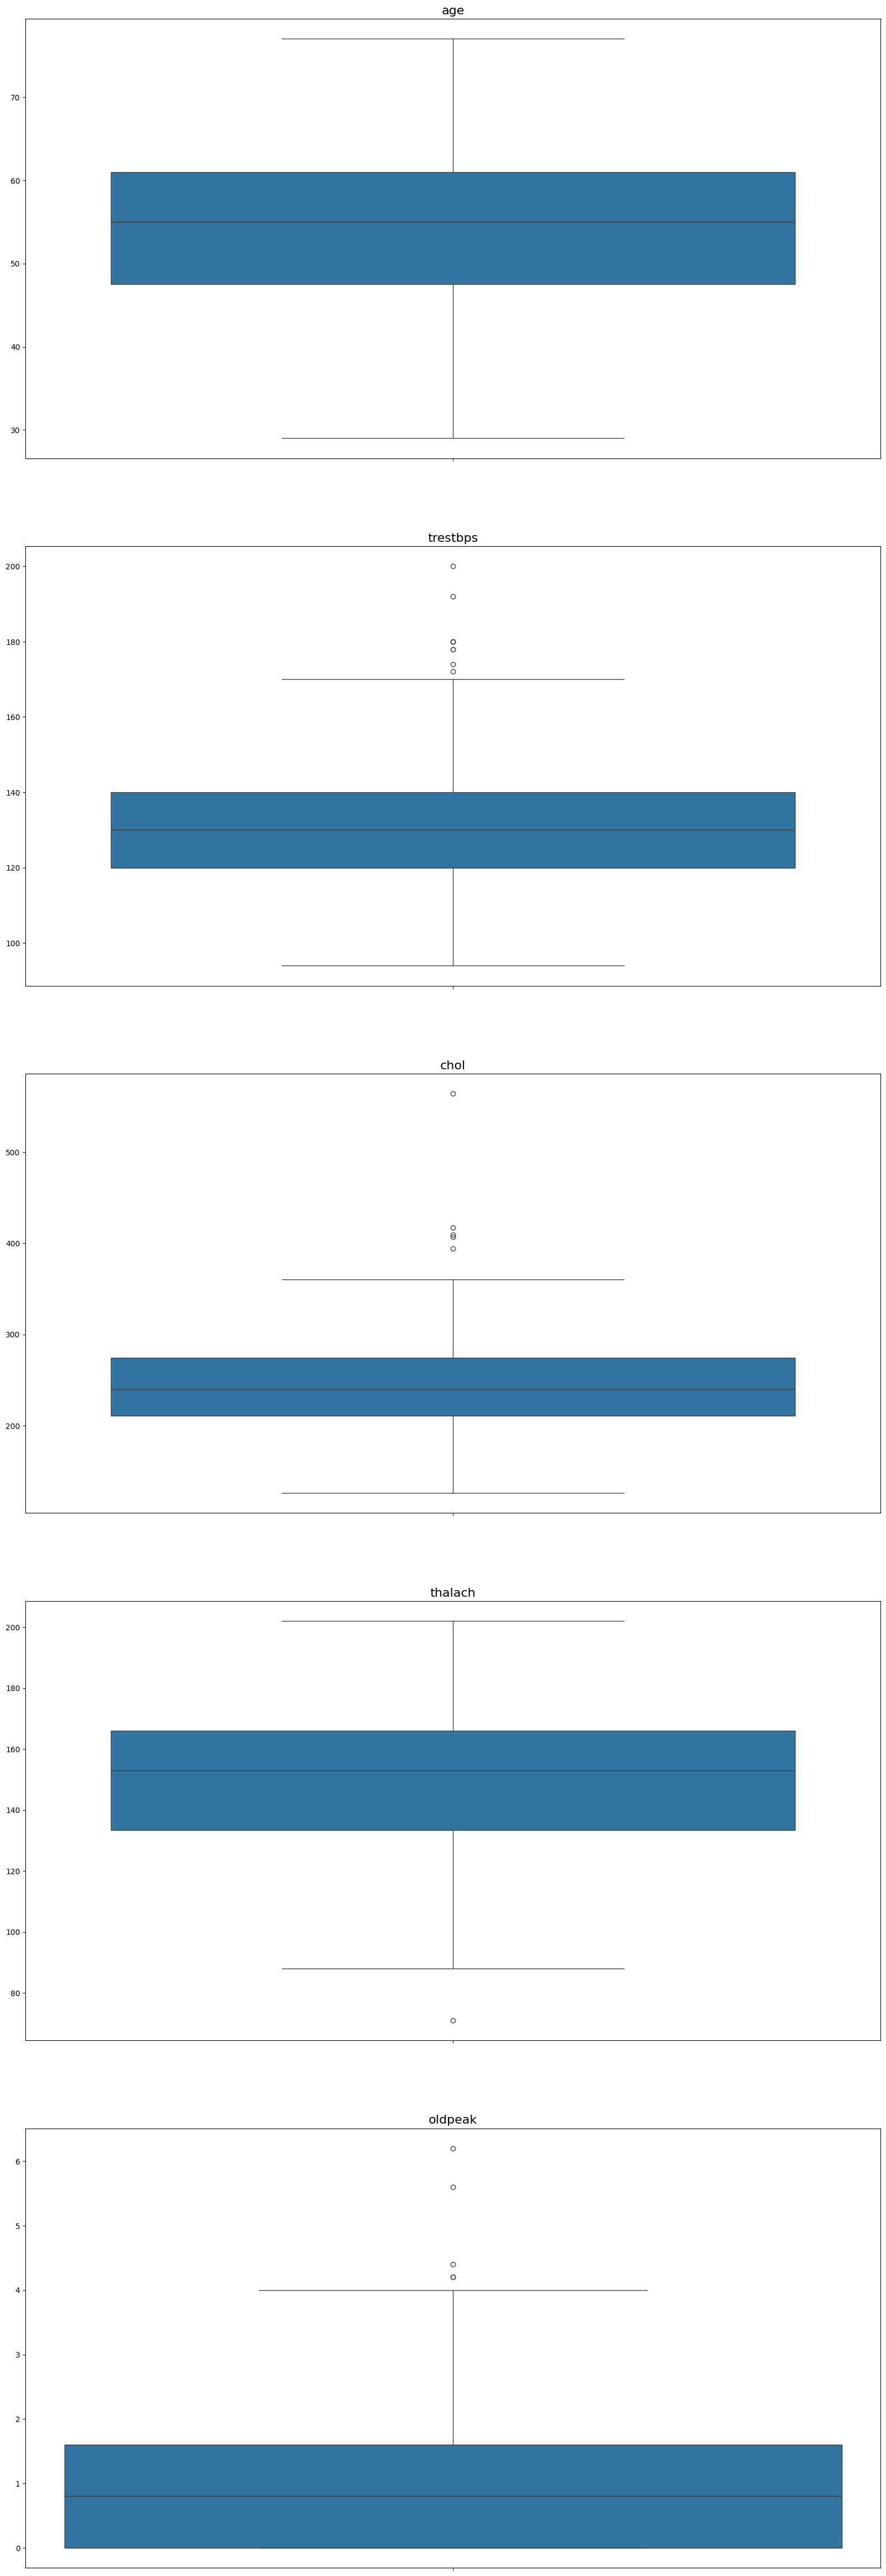

In [24]:
# Изучение дисперсии числовых признаков методов коробчатых диаграмм
fig, axes = plt.subplots(5,1,figsize=(20,60))

for i, ax in enumerate(axes.flatten()):
    sns.boxplot(y=num_feat[i], data=df_1, ax=ax)
    ax.set_ylabel(None)
    ax.set_title(label=num_feat[i], fontsize=16, fontweight='light')
plt.plot()

Гипотеза насчёт выбросов и видов распределений числовых переменных подтвердилась. Поэтому на этапе построения модели имеет смысл устранить эти выбросы одним из вышеперечисленных методов.

<Figure size 2400x1800 with 0 Axes>

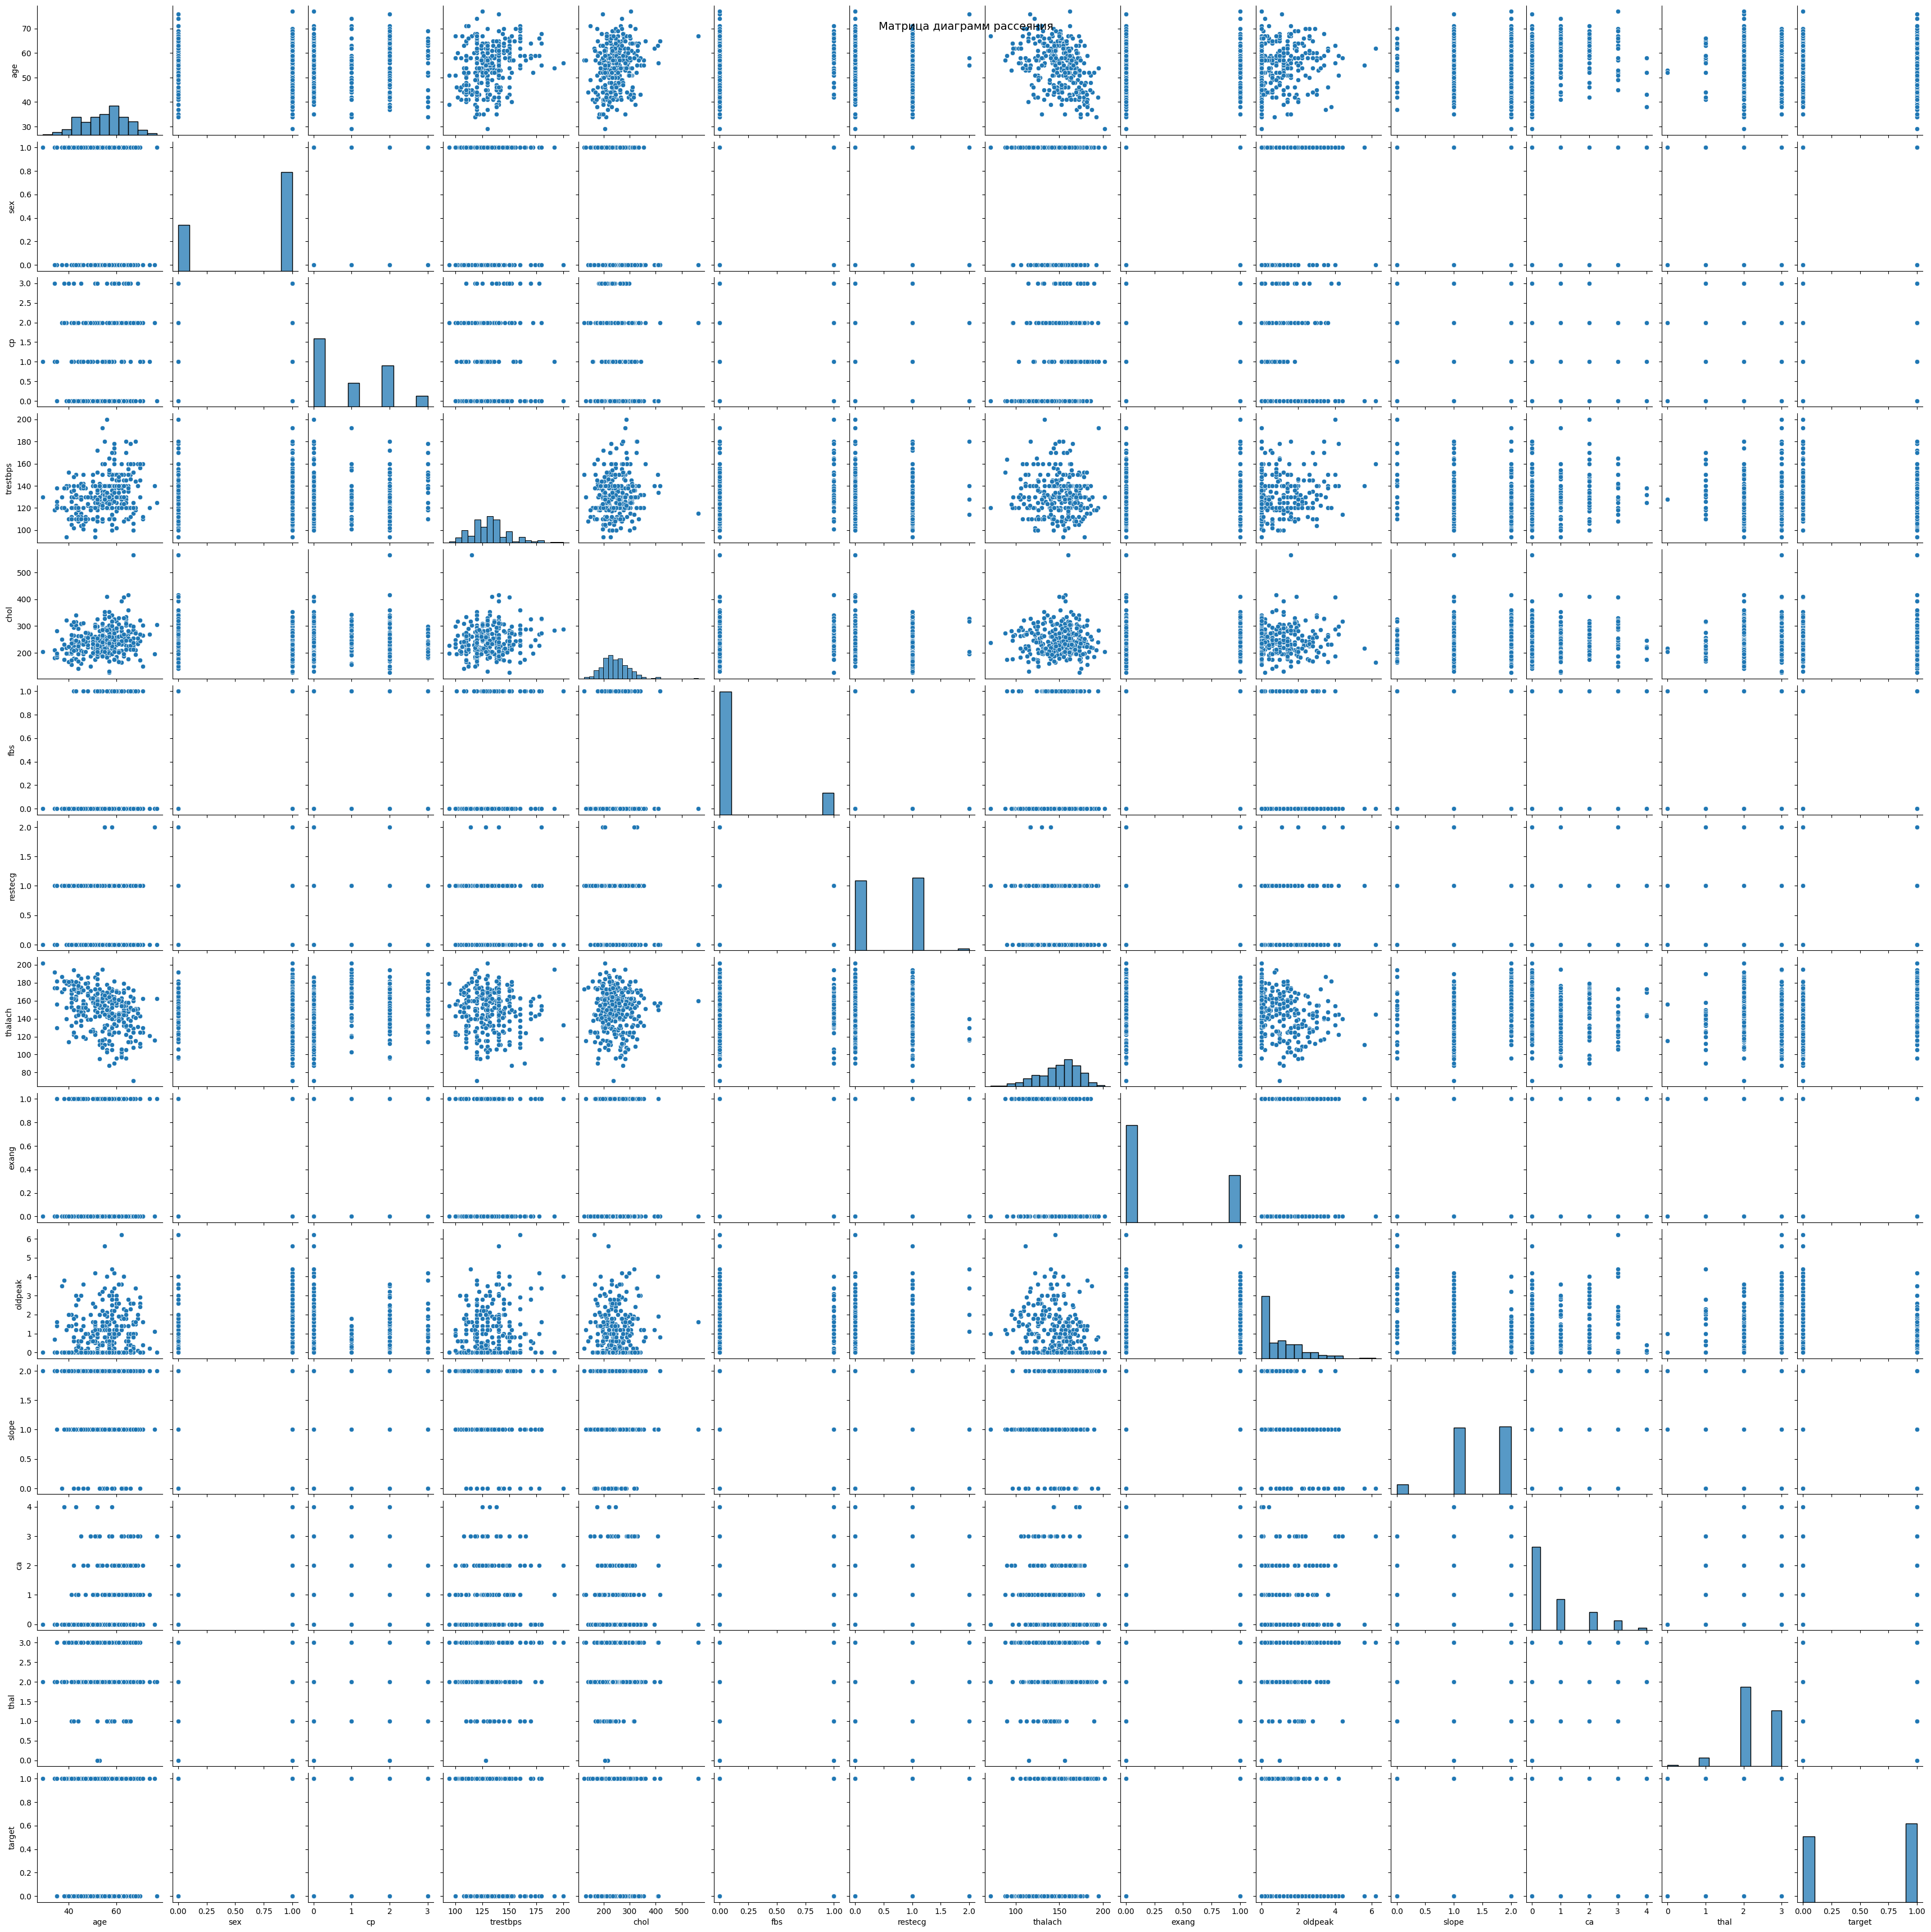

In [25]:
# Матрица диаграмм рассеяния

plt.figure(figsize=(24, 18))
sns.pairplot(data = df_1, palette = 'rainbow')
plt.suptitle('Матрица диаграмм рассеяния', fontsize = 14)
plt.show()

На матрице диаграмме рассеяния явно присутствуют зависимости между давлением и возрастом, а также между показателями между состоянием покоя и активности. Стоит изучить корреляционную матрицу зависимости признаков друг от друга.

<Axes: >

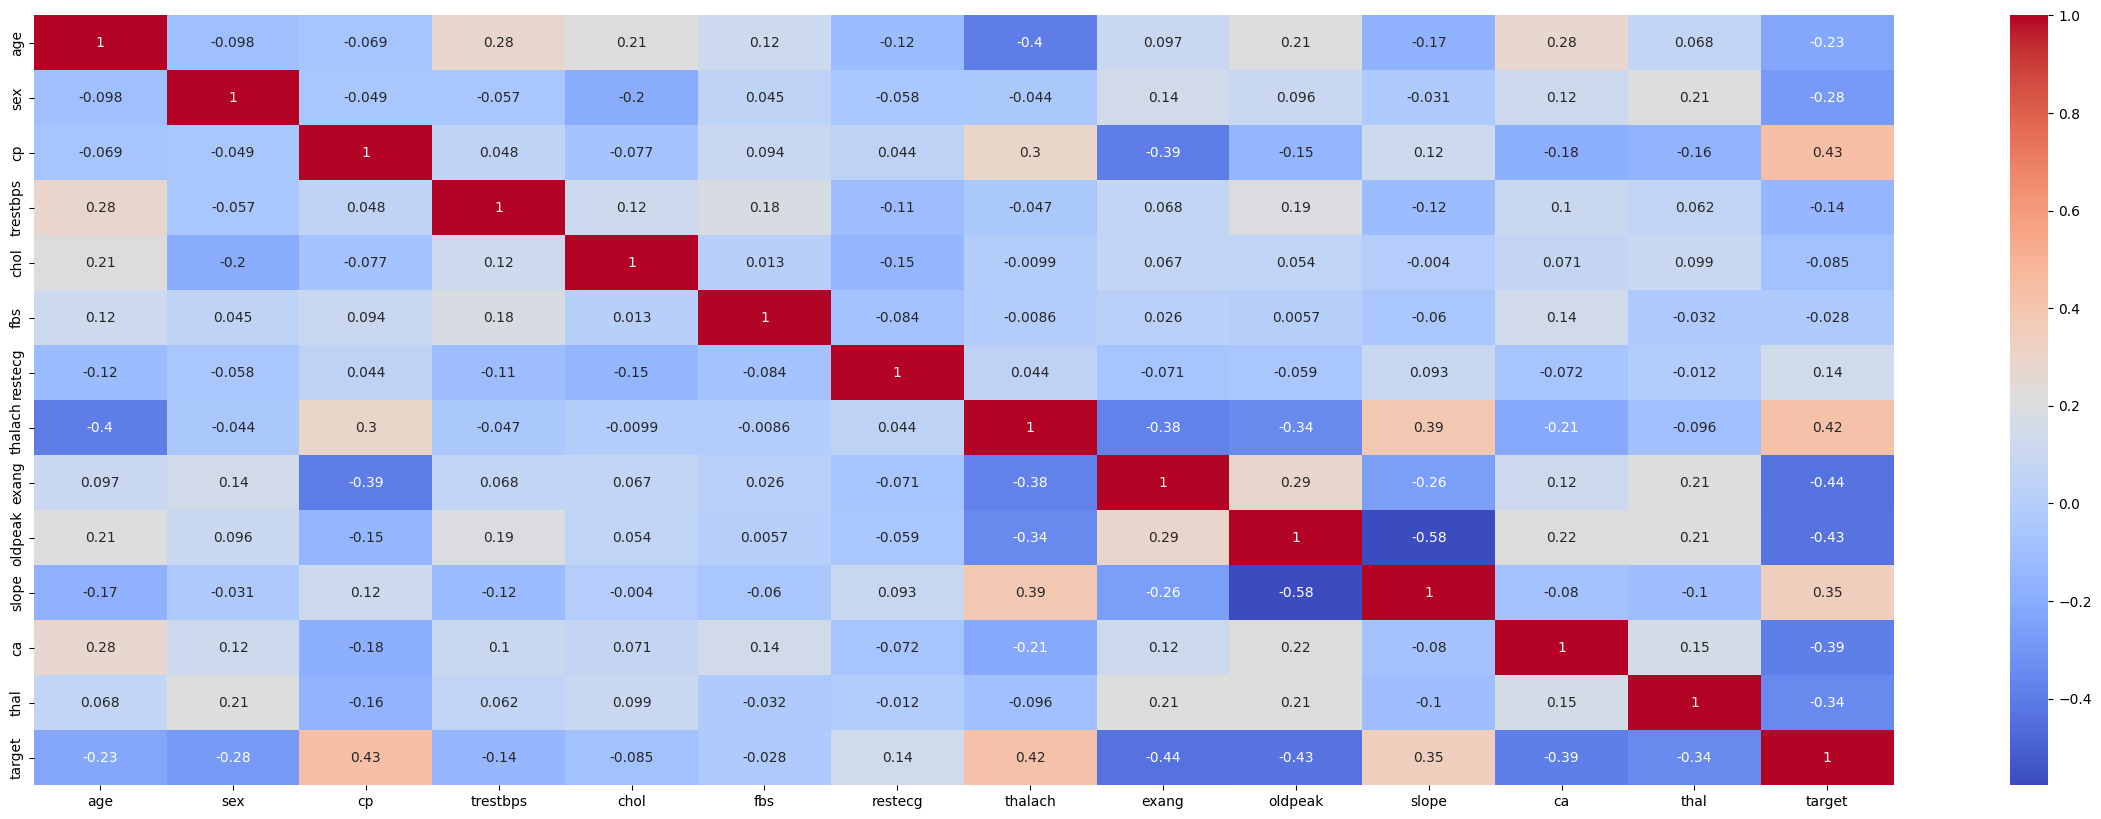

In [29]:
# Построим матрицу парных корреляций Построим тепловую карту матрицы парных коэффициентов корреляции
corr = df_1.corr()
plt.figure(figsize = (30, 10))
sns.heatmap(corr, annot = True, cmap = 'coolwarm', xticklabels = corr.columns, yticklabels = corr.columns)

В данной выборка явно наблюдаются прямые взаимосвязи между болями в груди, показателями в состоянии покоя и активности с проблемами в сердце (результирующей переменной). При этом гораздно более примечательны обратные взаимосвязи между показателями кардиограммы между собой (видимо это разносторонние пики) и с таргетом (видимо низкое значение некоторых пиков означает некоторую сердечную недостаточность), а также отсутствие болей в груди во время упражнений с таргетом (судя по всему в таком случае проблемы с сердцем протекают более незаметно для пациента).

В любом случае наличие таких сильных прямых и обратных взаимосвязий между переменными и с таргетом говорит о наличии мультиколлинеарности и наличии явных киллер-фичей при построении модели. При построеннии модели очевидно сильно пострадаёт её достоверность вне зависимости от показателей метрик. Следует нивелировать дисперсию признаков путём перевода их в пространство главных компонент, а также предварительно закодировать категориальные переменные.

## Изучение срезов данных

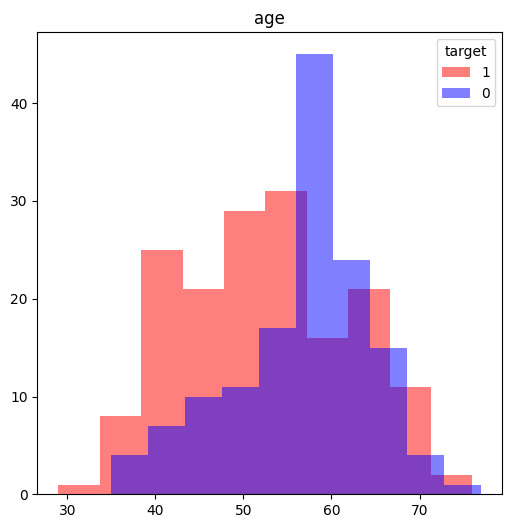

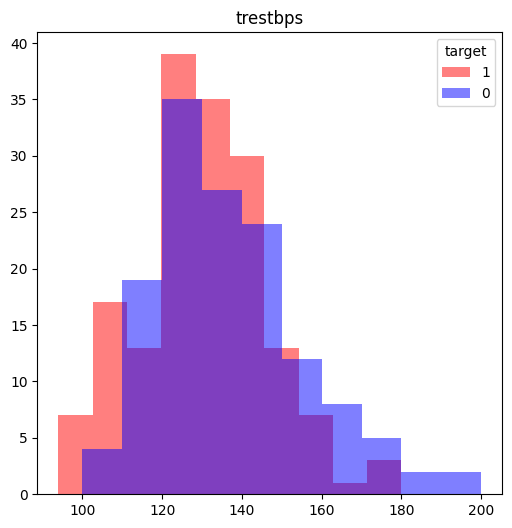

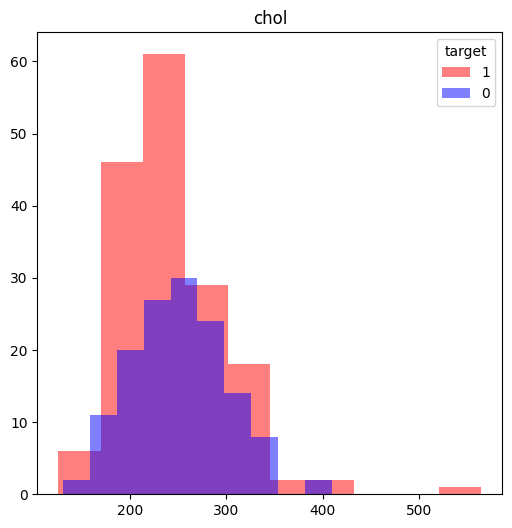

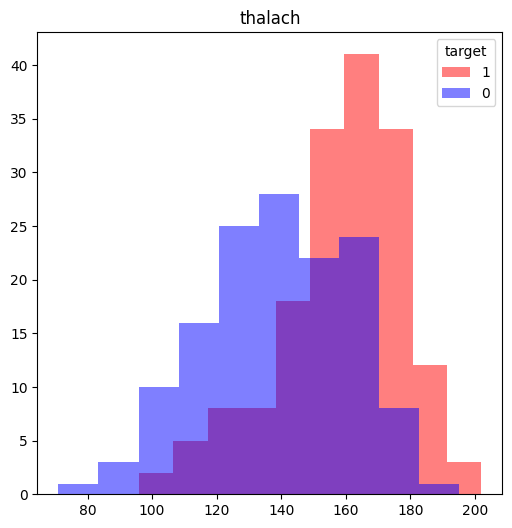

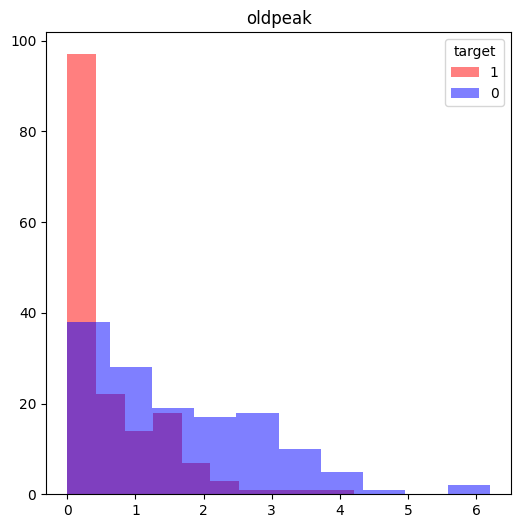

In [31]:
# Распределение числовых переменных в разрезе таргета
for col in num_feat: 
    plt.figure(figsize=(6,6))
    plt.hist(x=col, data=df_1[df_1['target']==1], color='r', alpha = 0.5)
    plt.hist(x=col, data=df_1[df_1['target']==0], color='b', alpha = 0.5)
    plt.title(col)
    plt.legend([1,0],title='target')

В зависимости от наличия проблем с сердцем распределения явно различаются также соразмерно прямой и обратной корреляционной зависимости. Возможно, что замену уникальных значений следует производить с учётом целевой переменной и смещений соответствующих распределений. Исходя из представленных распределений очевидно будут отличаться и дисперсии числовых признаков.

[]

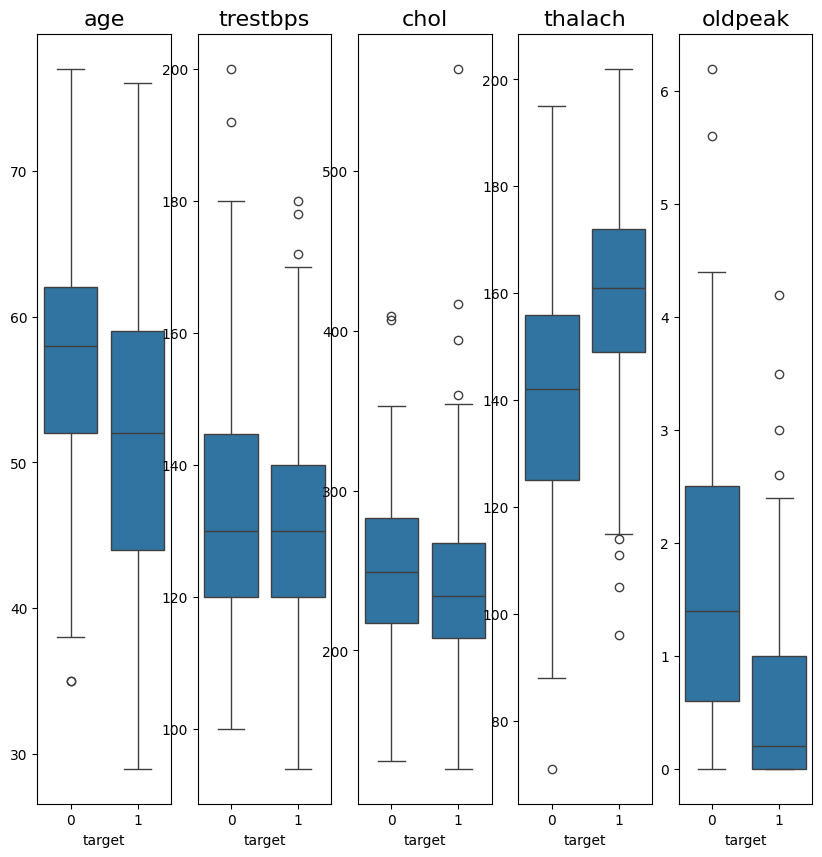

In [37]:
#card_call
fig, axes = plt.subplots(1,5,figsize=(10,10))

for i, ax in enumerate(axes.flatten()):
    sns.boxplot(x ='target', y=num_feat[i], data=df_1, ax=ax)
    ax.set_ylabel(None)
    ax.set_title(label=num_feat[i], fontsize=16, fontweight='light')
plt.plot()

Большинство отклонений безусловно связаны с фактом наличия кардиологических отклонений.

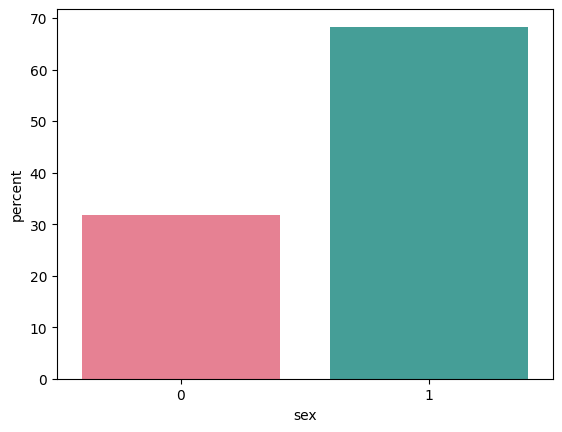

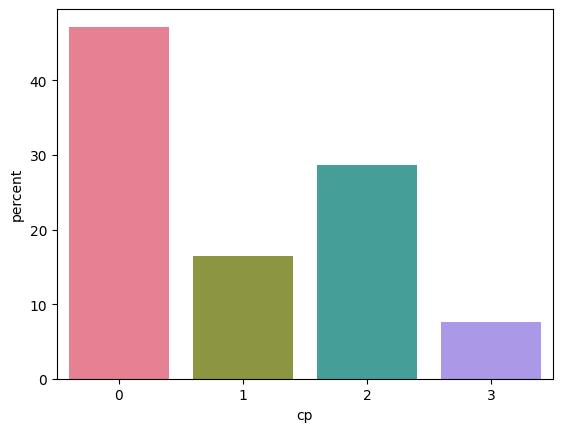

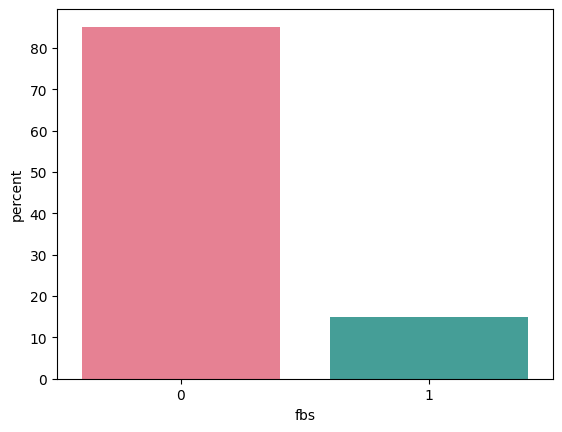

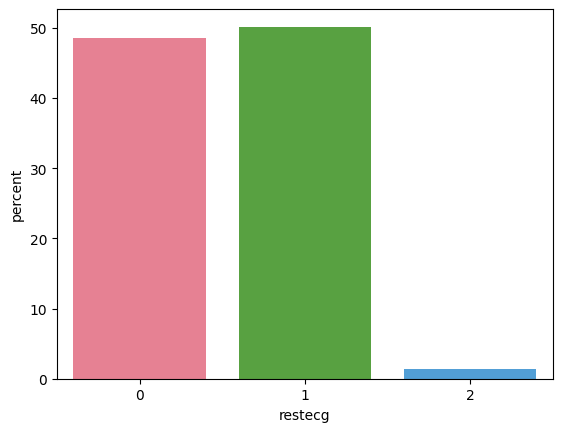

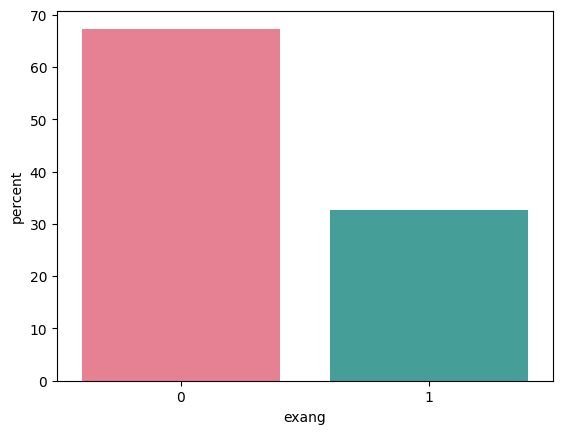

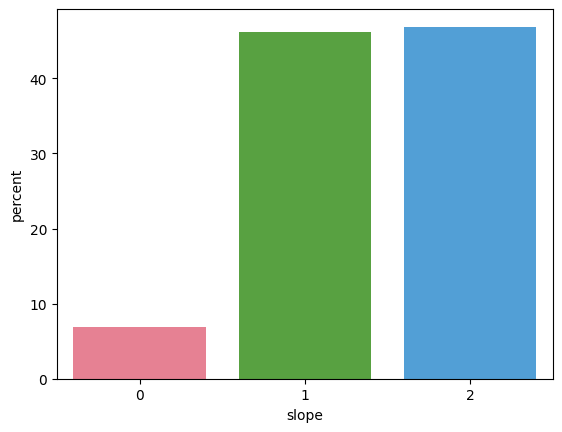

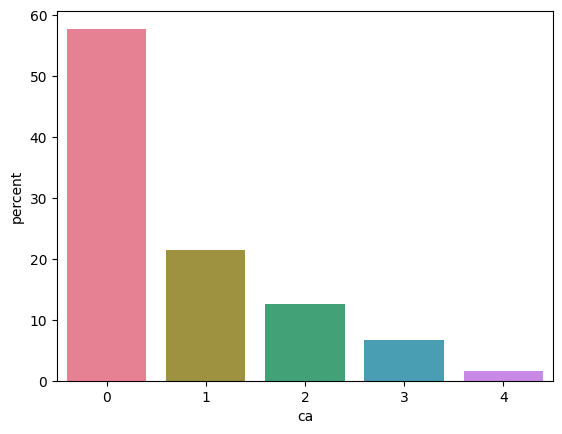

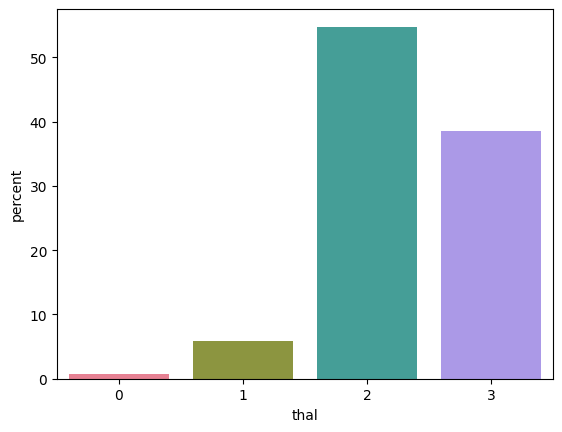

In [40]:
# Категориальные столбцы
for col in df_1[df_1['target'] == 1][cat_feat]:
    sns.countplot(df_1, x=col, stat='percent', palette='husl')
    plt.show()

Категориальные признаки имеют равные распределения вне зависимости от таргета.

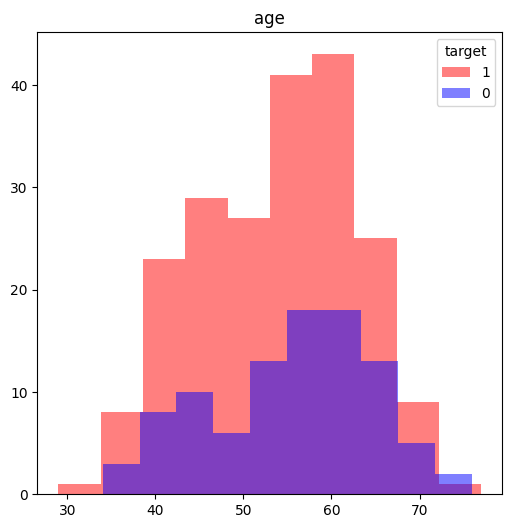

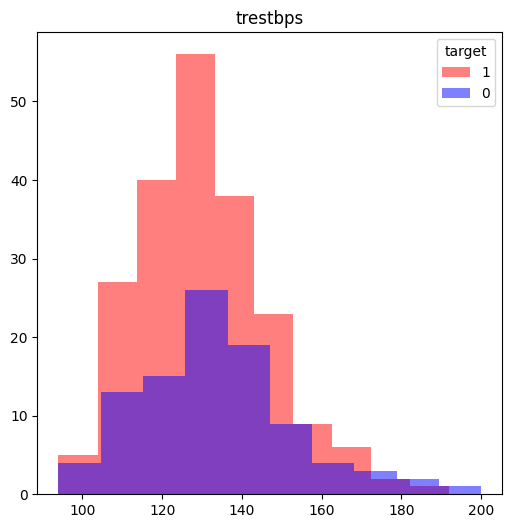

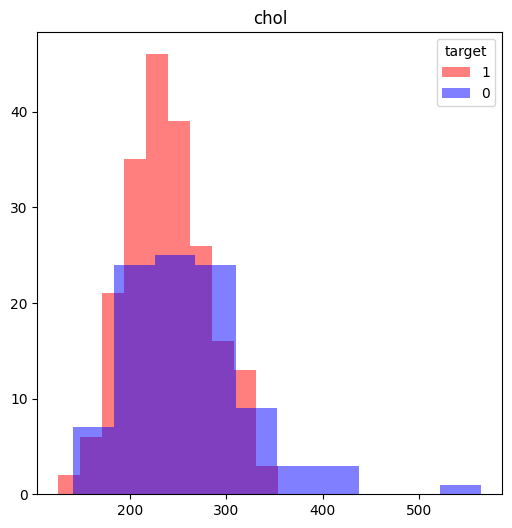

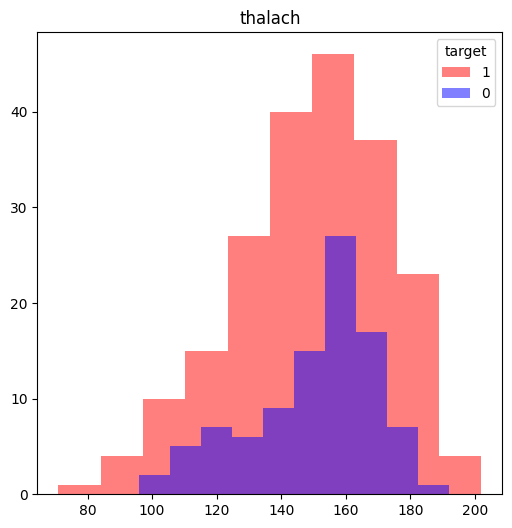

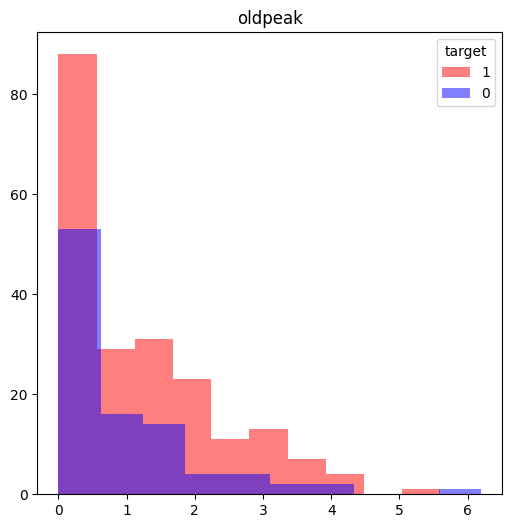

In [41]:
# Распределение числовых переменных в разрезе пола
for col in num_feat: 
    plt.figure(figsize=(6,6))
    plt.hist(x=col, data=df_1[df_1['sex']==1], color='r', alpha = 0.5)
    plt.hist(x=col, data=df_1[df_1['sex']==0], color='b', alpha = 0.5)
    plt.title(col)
    plt.legend([1,0],title='target')

В разрезе пола числовые переменное имеют примерно одинаковые виды распределений с учётом того, что женщин в выборке примерно в два раза меньше, чем мужчин.

# Dataset 2

## Загрузка и предварительное изучение столбцов

In [43]:
# Загрузка датасета
df_2 = pd.read_csv('..\\data\\cardio_train.csv', delimiter=';')
df_2.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [45]:
df_2.shape # Размерность

(70000, 13)

Описание первого датасета:

В первом датафрейме имеется всего 13 столбцов и 70000 наблюдений, чего вполне достаточно для построения достаточно достоверной модели с приемлемыми доверительными интервалами.

Краткое описание столбцов:

* age - возраст
* gender - пол
* height - рост
* weight - вес
* ap_hi - верхнее давление
* ap_lo - нижнее давление
* cholesterol - уровень холестерина
* gluc - уровень глюкозы
* smoke - статус курения
* alco - употребление алкоголя
* active - физическая активность

In [49]:
# Пропуски
df_2.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [48]:
# Проверка на наличие явных дубликатов
df_2.duplicated().sum()

np.int64(0)

In [50]:
# Описательная статистика
df_2.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Столбец id явно является индексом и не представляет статистического интереса.

Числовыми столбцами являются возраст, рост, вес, артериальное и внутрисердечного давление.

В качестве категориальных столбцов явно можно выделить пол, уровень холестерина в крови (низкий, средний и высокий), уровень глюкозы в крови, флаги курения, употребления алкоголя и активного образа жизни.

Переменная cardio является целевой и по смыслу аналогична предыдущему датасету.

In [51]:
df_2.nunique()

id             70000
age             8076
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

## Графическое изучение структуры данных

In [52]:
# категориальные и числовые столбцы
cat_feat_2 = [
                'gender',
                'cholesterol',
                'gluc',
                'smoke',
                'alco',
                'active'
            ]
num_feat_2 = [
                'age',
                'height',
                'weight',
                'ap_hi',
                'ap_lo'
            ]

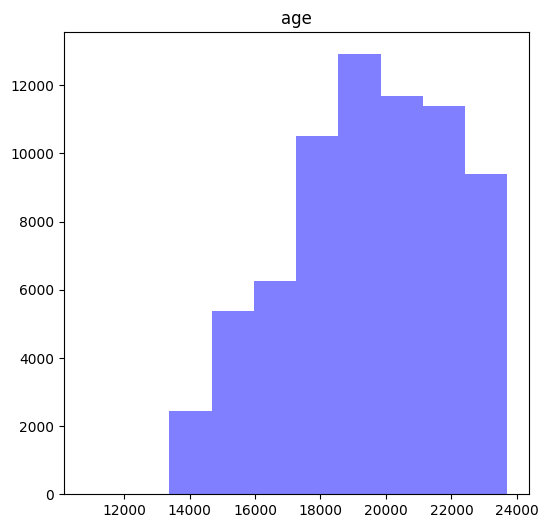

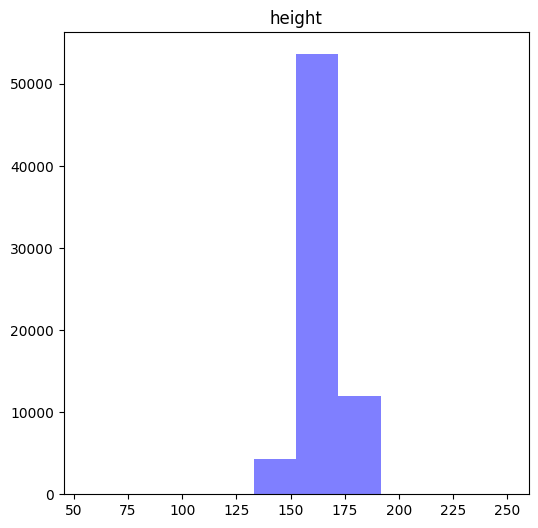

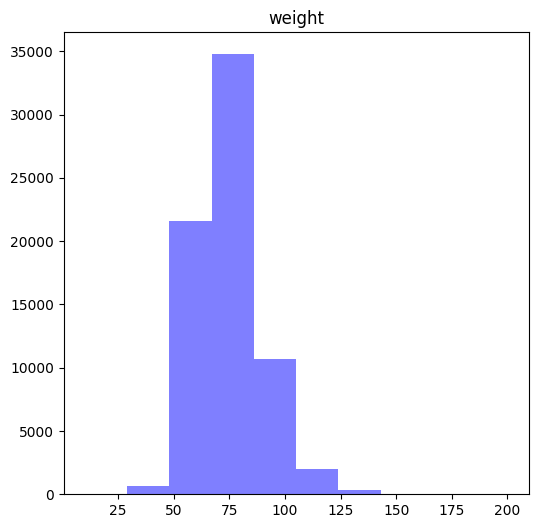

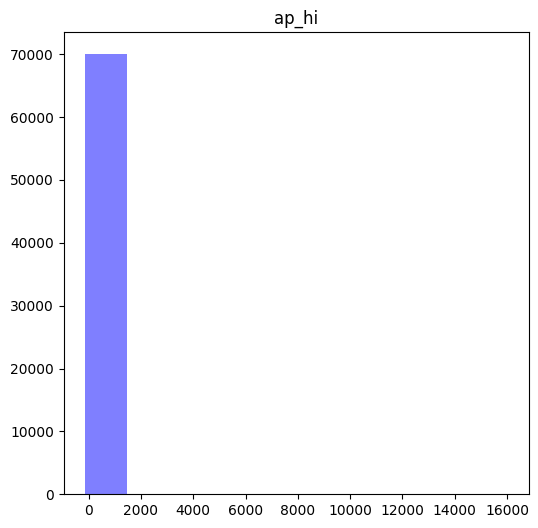

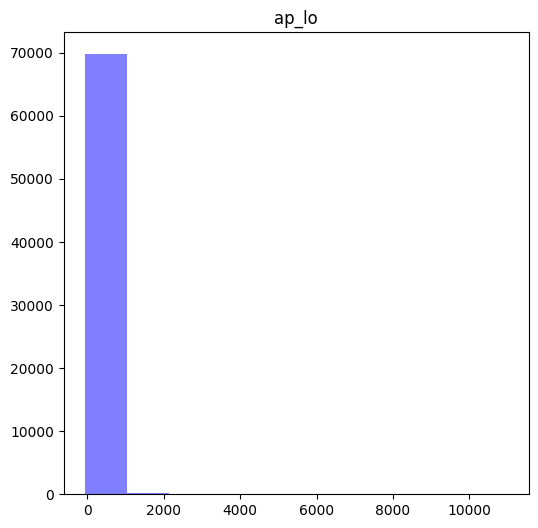

In [53]:
# Распределения числовых столбцов
for col in num_feat_2:
    plt.figure(figsize=(6,6))
    plt.hist(x=col, data=df_2, color='b', alpha = 0.5)
    plt.title(col)

Числовые переменные явно имеют аномальные значения, однако форма их распределения явно близка к нормальному. Исправление ошибок в данном случае явно возможно раннеописанным способом подгона к нормальному распределению. В качестве параметров к данным распределениям отлично могут подойти соответстующие данные из первого датасета в разбивке по таргету и полу соответственно. Для роста и веса прекрасно могут подойти среднестатистические распределения с учётом склонностей к кардиологическим проблемам.

В связи с этим до переопределения числовых признаков не имеет смысла оценивать дисперсии и выбросы в виду того, что они будут заданы заново.

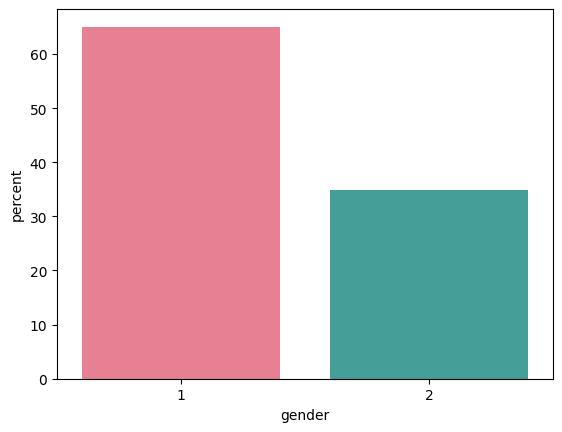

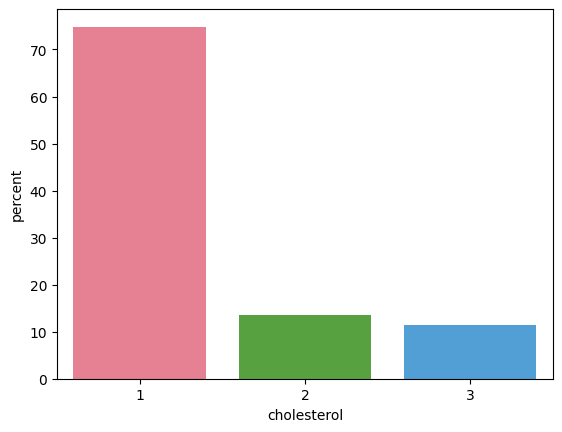

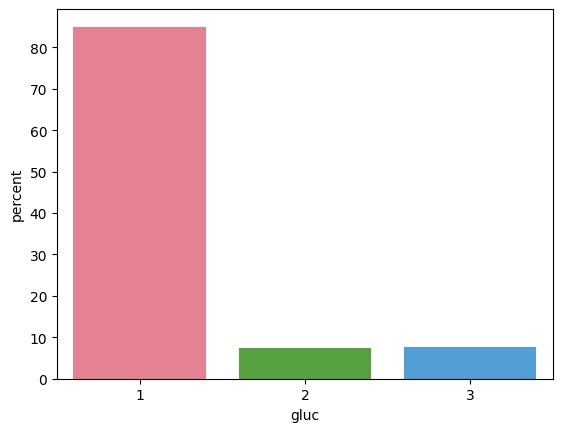

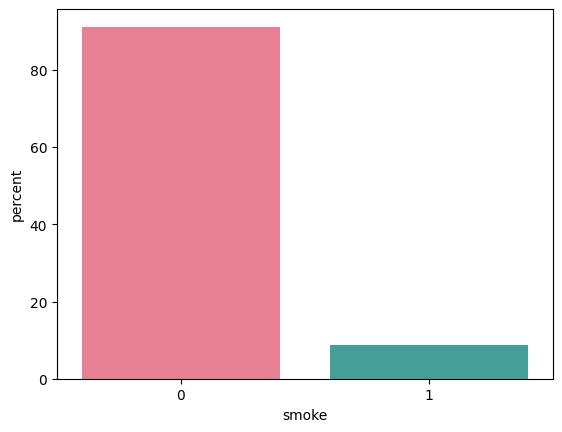

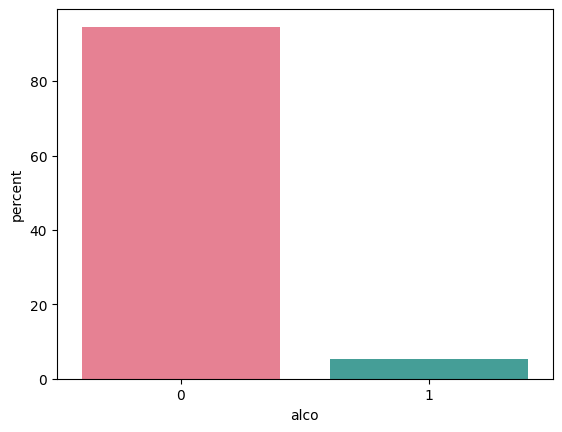

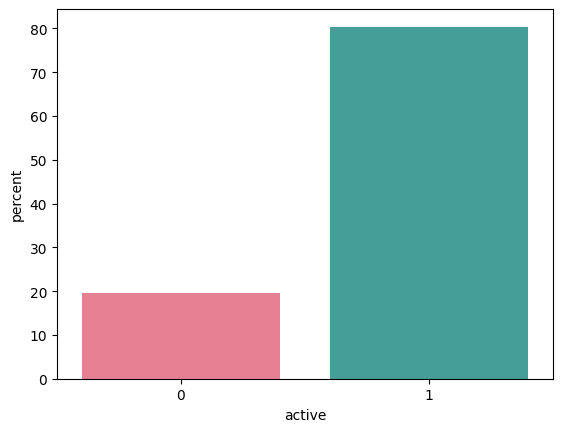

In [55]:
# Категориальные столбцы
for col in df_2[cat_feat_2]:
    sns.countplot(df_2, x=col, stat='percent', palette='husl')
    plt.show()

Категориальные переменные соотносятся по аналогичному принципу предыдущего набора данных.

<Axes: >

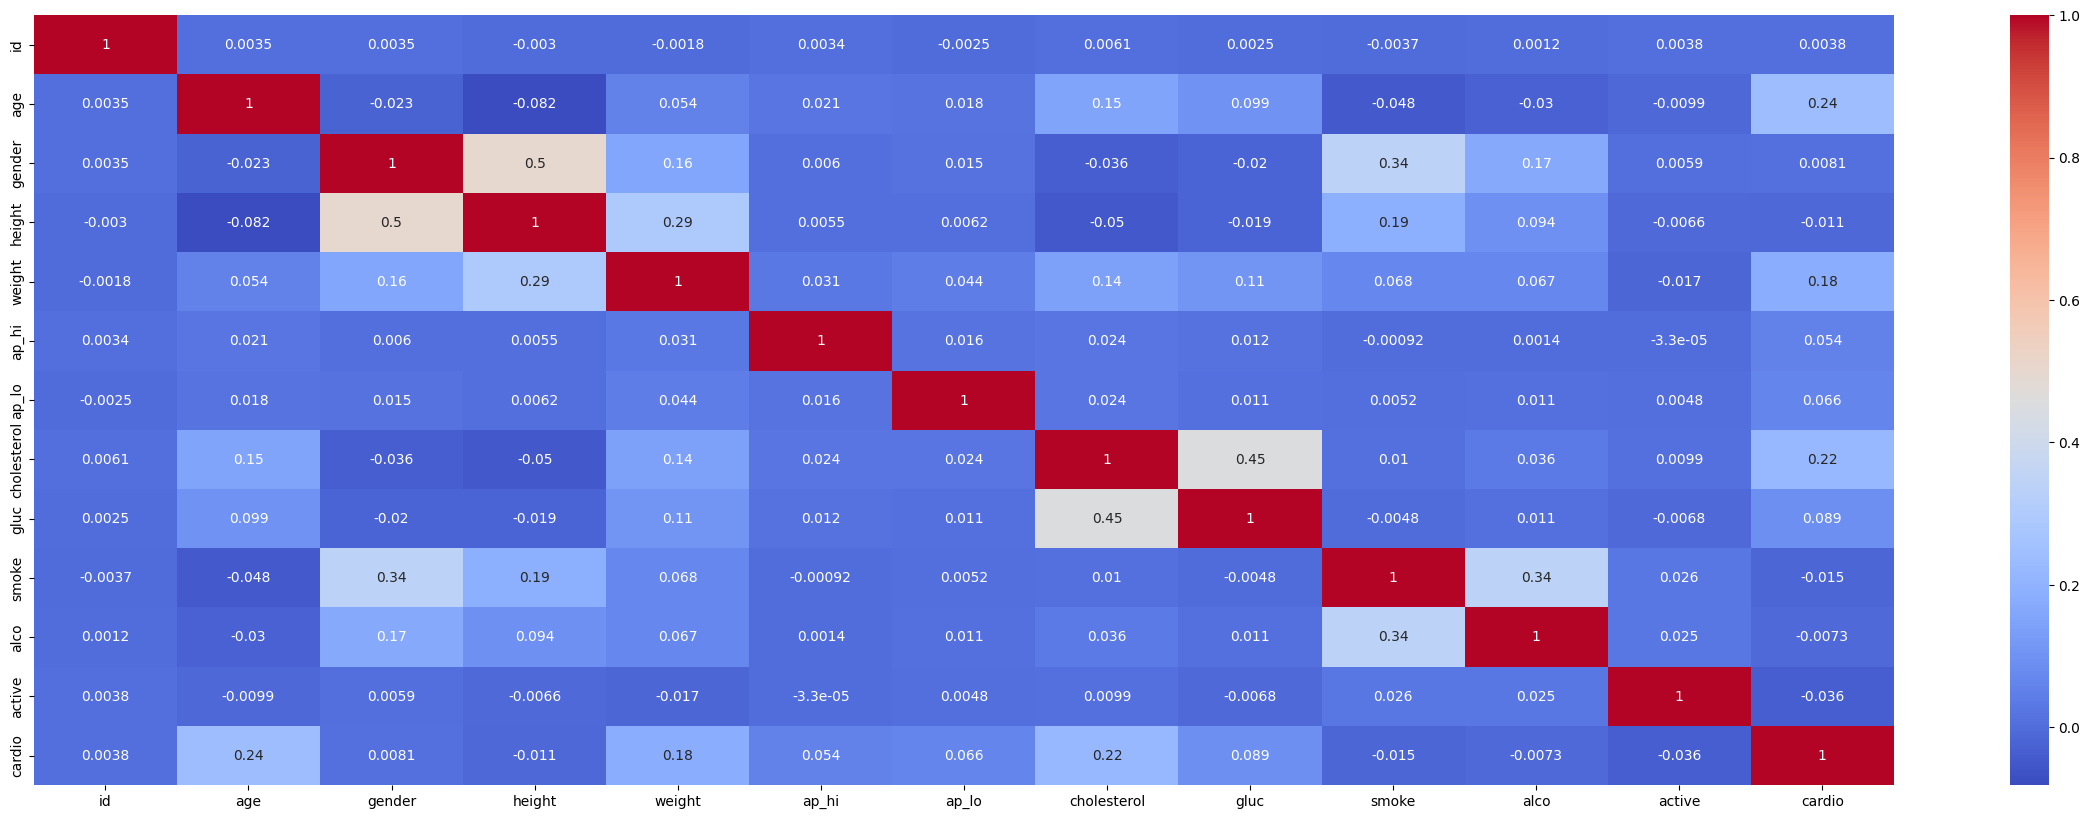

In [56]:
# Построим матрицу парных корреляций Построим тепловую карту матрицы парных коэффициентов корреляции
corr = df_2.corr()
plt.figure(figsize = (30, 10))
sns.heatmap(corr, annot = True, cmap = 'coolwarm', xticklabels = corr.columns, yticklabels = corr.columns)

Достаточно сильные прямые взаимосвязи имеют пол с ростом, а также уровень глюкозы и холестерина в крови. Курение также прямо связано с полом. Некорректно распределённые числовые переменные в виду своей аномальности не имеют какой-то прямой взаимосвязи с лругими переменными. Это ещё раз говорит о необходимости их подгона под соответствующие срезы данных.

## Изучение срезов данных

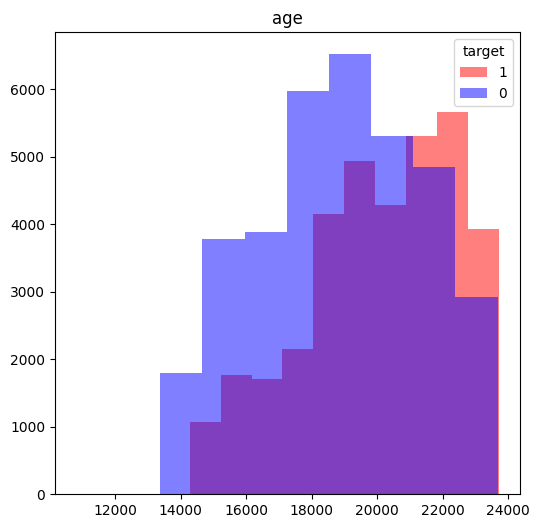

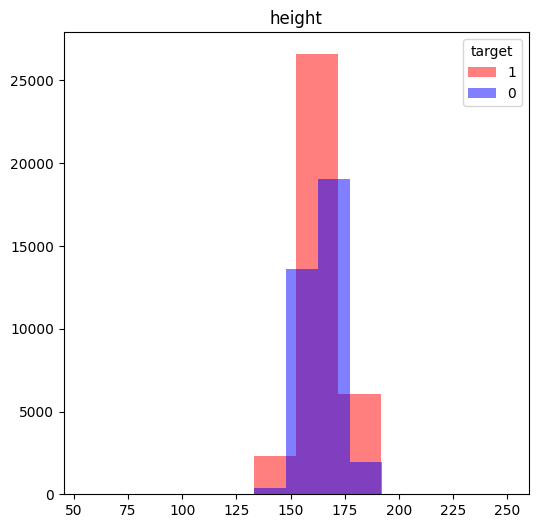

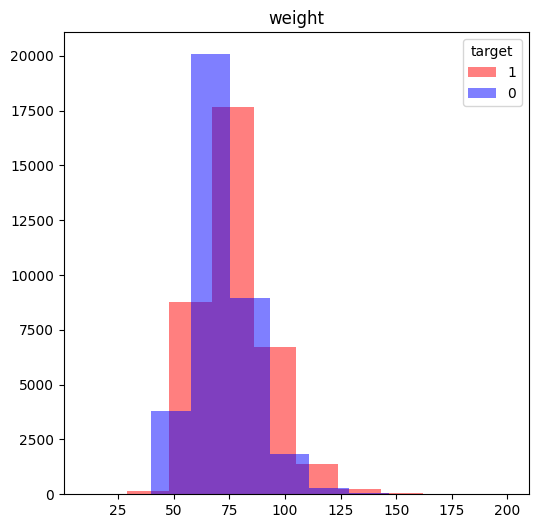

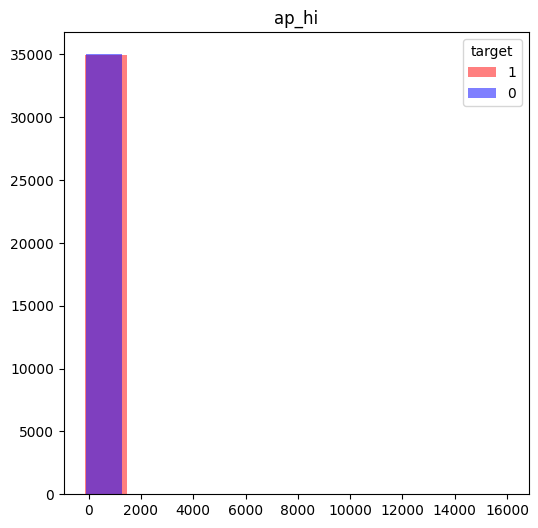

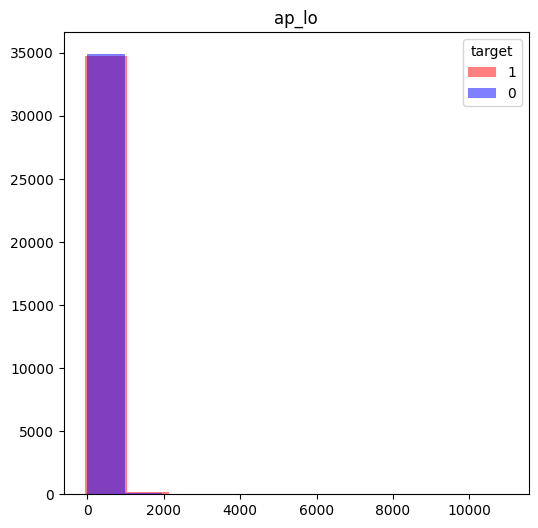

In [58]:
# Распределение числовых переменных в разрезе таргета
for col in num_feat_2: 
    plt.figure(figsize=(6,6))
    plt.hist(x=col, data=df_2[df_2['cardio']==1], color='r', alpha = 0.5)
    plt.hist(x=col, data=df_2[df_2['cardio']==0], color='b', alpha = 0.5)
    plt.title(col)
    plt.legend([1,0],title='target')

В целом, форма распределений некорректных столбцов совпадает с предыдущим датафреймом, следовательно не должно возникнуть проблем с их заменой.

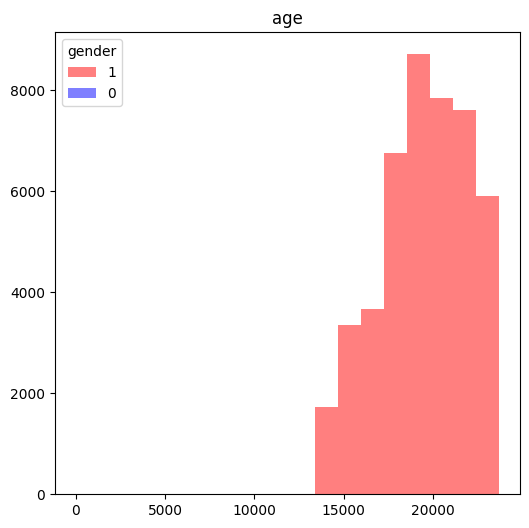

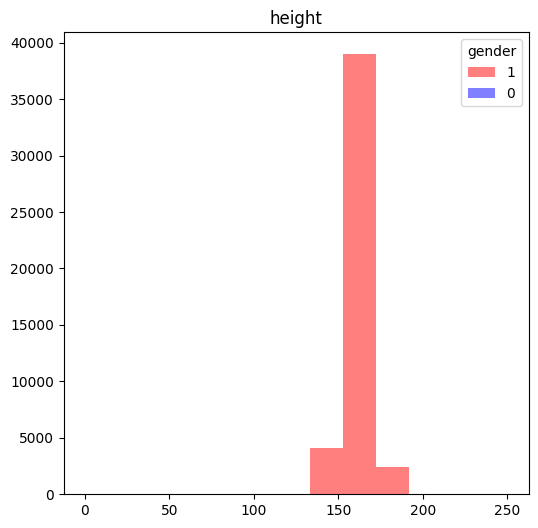

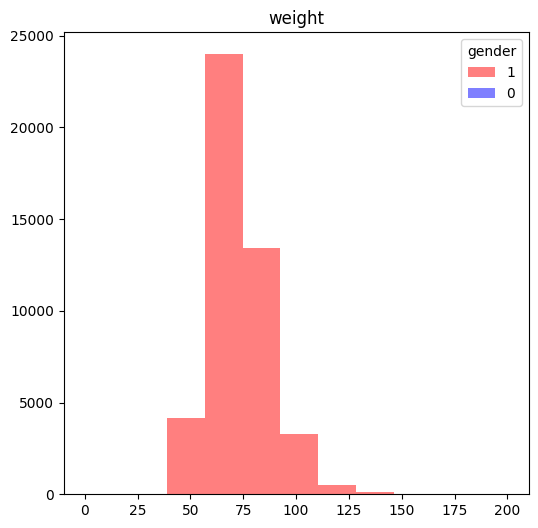

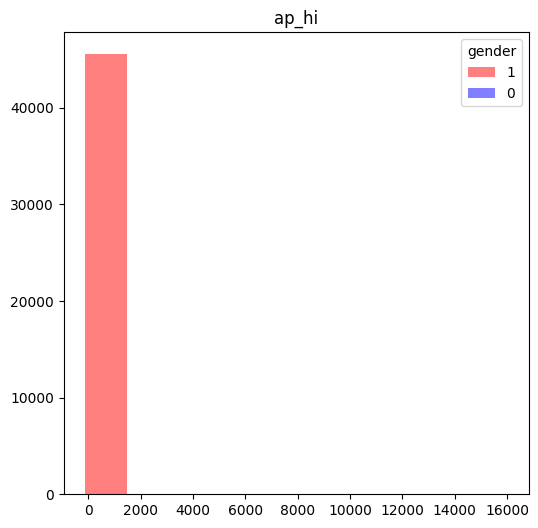

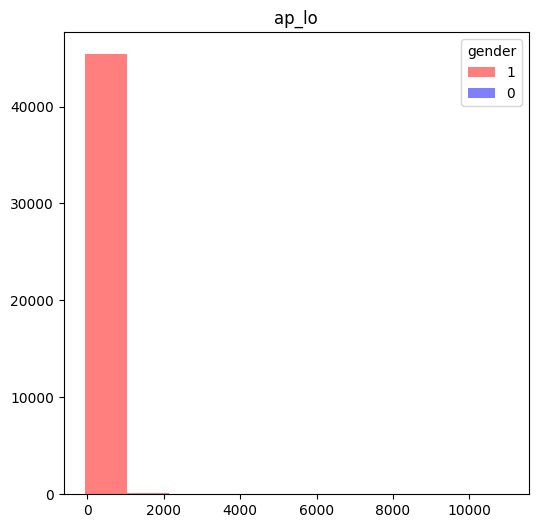

In [59]:
# Распределение числовых переменных в разрезе пола
for col in num_feat_2: 
    plt.figure(figsize=(6,6))
    plt.hist(x=col, data=df_2[df_2['gender']==1], color='r', alpha = 0.5)
    plt.hist(x=col, data=df_2[df_2['gender']==0], color='b', alpha = 0.5)
    plt.title(col)
    plt.legend([1,0],title='gender')

Распределения в целом наложены друг на друга и совпадают.

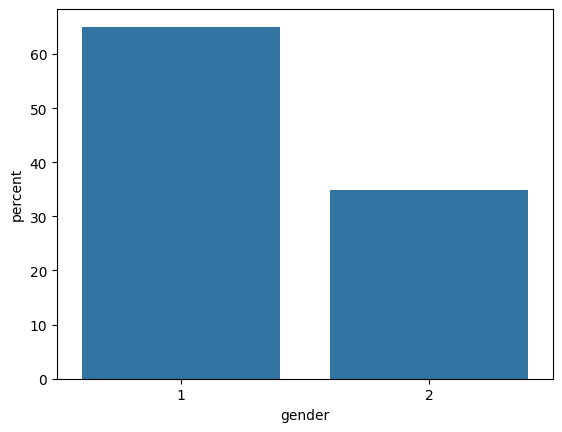

In [62]:
sns.countplot(df_2, x='gender', stat='percent')
plt.show()

In [60]:
df_2['gender'].value_counts(normalize=True)

gender
1    0.650429
2    0.349571
Name: proportion, dtype: float64

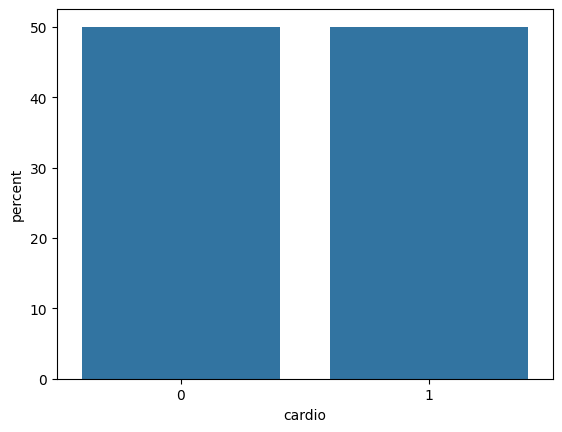

In [64]:
sns.countplot(df_2, x='cardio', stat='percent')
plt.show()

In [61]:
df_2['cardio'].value_counts(normalize=True)

cardio
0    0.5003
1    0.4997
Name: proportion, dtype: float64

# A/B тестирование

In [65]:
df_1.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [66]:
# Шапиро-Уилк (равенство средних) по таргету и полу
for tg in np.sort(df_1['target'].unique()):
    data = df_1[df_1['target'] == tg]
    model = ols('sex ~ target', data = data).fit()
    print('Target: ',tg, '\nResults: ', st.shapiro(model.resid))
    print('')

Target:  0 
Results:  ShapiroResult(statistic=np.float64(0.45862007234708113), pvalue=np.float64(1.95548615293815e-20))

Target:  1 
Results:  ShapiroResult(statistic=np.float64(0.6304946168320983), pvalue=np.float64(1.0158196594857565e-18))



p-value при уровне значимости альфа = 0.01 и значения теста принимают нулевую гипетозу (в среднем проблемы сердца у мужчин и женщин встречаются одинаково), следовательно, не имеет смысла в срезе для второго датафрейма учитывать пол, достаточно непосредственный таргет.

In [67]:
df_2.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [68]:
# Аналогично для второго датафрейма
for tg in np.sort(df_2['cardio'].unique()):
    data = df_2[df_2['cardio'] == tg]
    model = ols('gender ~ cardio', data = data).fit()
    print('Target: ',tg, '\nResults: ', st.shapiro(model.resid))
    print('')

Target:  0 
Results:  ShapiroResult(statistic=np.float64(0.6010553840049665), pvalue=np.float64(2.4903110348603505e-125))

Target:  1 
Results:  ShapiroResult(statistic=np.float64(0.6046202353144153), pvalue=np.float64(4.8368099438525e-125))



Гипотеза для второго датафрейма аналогично первому.

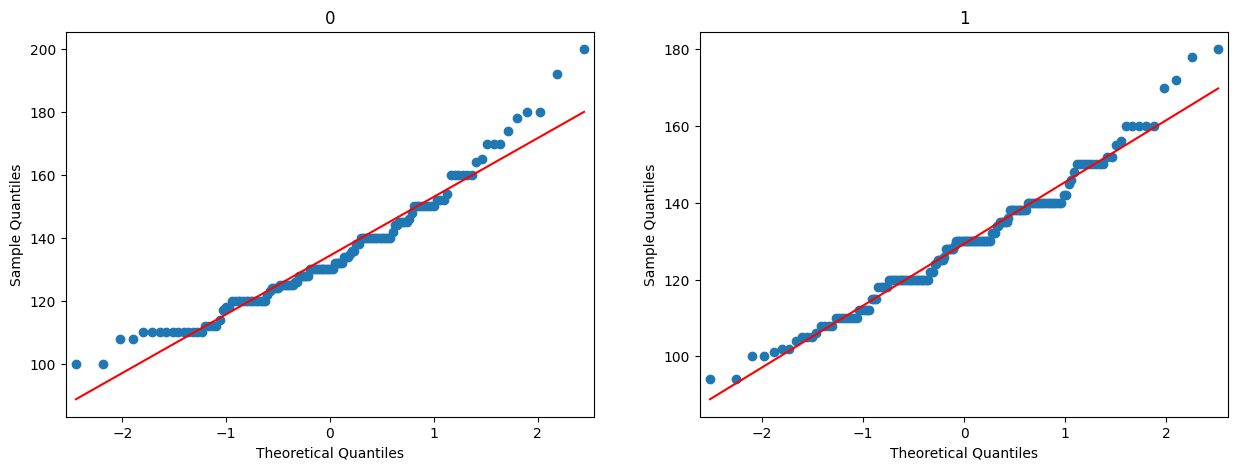

In [70]:
# Давление в состоянии покоя
fig , axs = plt.subplots(1,2,figsize=(15,5))
qqplot(np.array(df_1[df_1['target']==0]['trestbps']), line = 's', ax = axs[0])
qqplot(np.array(df_1[df_1['target']==1]['trestbps']), line = 's', ax = axs[1])



axs[0].set_title("0")
axs[1].set_title("1")
plt.show()

Для таргетов явно выделяются теоретические квантили в состоянии покоя (как и выбросы).

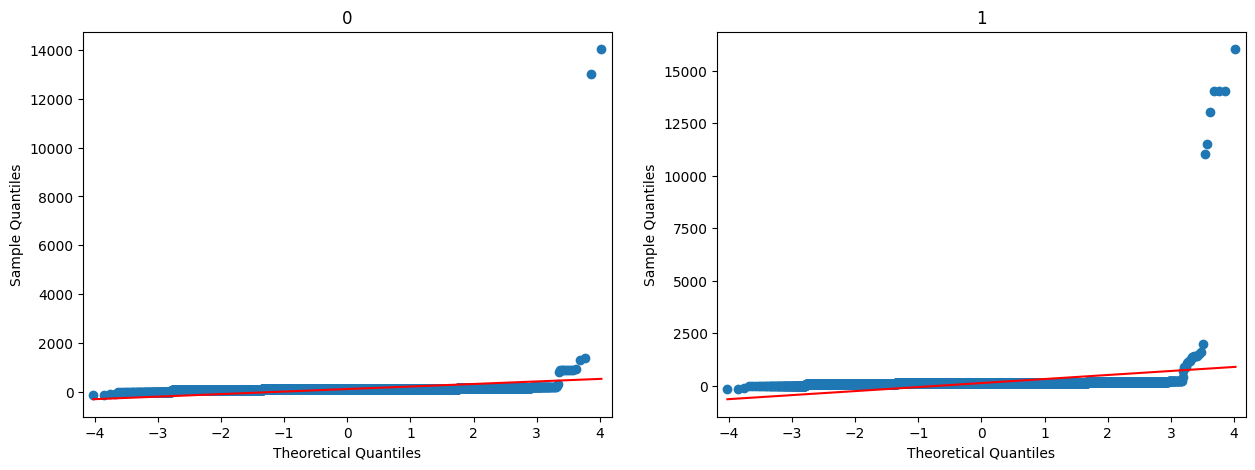

In [71]:
# Аналогично для второго датасета
# Давление в состоянии покоя
fig , axs = plt.subplots(1,2,figsize=(15,5))
qqplot(np.array(df_2[df_2['cardio']==0]['ap_hi']), line = 's', ax = axs[0])
qqplot(np.array(df_2[df_2['cardio']==1]['ap_hi']), line = 's', ax = axs[1])



axs[0].set_title("0")
axs[1].set_title("1")
plt.show()

Верхнее давление во втором датасете явно нуждается в приведении к нормальному виду.

In [73]:
# Тест Левенью
for i in num_feat:
       print(i, levene(df_1[df_1['target']==0][i], 
              df_1[df_1['target']==1][i]))

age LeveneResult(statistic=np.float64(7.985421542102045), pvalue=np.float64(0.005030946112241477))
trestbps LeveneResult(statistic=np.float64(1.8569845481574663), pvalue=np.float64(0.17399187776048733))
chol LeveneResult(statistic=np.float64(0.10146349230966614), pvalue=np.float64(0.7503013119536838))
thalach LeveneResult(statistic=np.float64(5.246661549713764), pvalue=np.float64(0.022680140675291966))
oldpeak LeveneResult(statistic=np.float64(32.91633445691929), pvalue=np.float64(2.3439741300280836e-08))


Показатели давления, кардиограммы и холистерина диспеосионно неравны по таргету, значит, обладают некоторой объясняющей способностью.

In [77]:
cols_1 = df_1.drop('target', axis=1).columns
cols_2 = df_2.drop(['cardio', 'id'], axis=1).columns

In [79]:
# Непараметрический тест Краскала на равенство дисперсий (однофакторный дисп. анализ)
for i in cols_1:
       print(i, kruskal(df_1[df_1['target']==0][i], 
              df_1[df_1['target']==1][i]))

age KruskalResult(statistic=np.float64(17.164047297707278), pvalue=np.float64(3.4286444446753614e-05))
sex KruskalResult(statistic=np.float64(23.8354585553072), pvalue=np.float64(1.0493157073364874e-06))
cp KruskalResult(statistic=np.float64(64.1424146048031), pvalue=np.float64(1.1574276422291982e-15))
trestbps KruskalResult(statistic=np.float64(4.46500877422218), pvalue=np.float64(0.03459591199011507))
chol KruskalResult(statistic=np.float64(4.4134180185489065), pvalue=np.float64(0.03565732718705455))
fbs KruskalResult(statistic=np.float64(0.23754253012071513), pvalue=np.float64(0.6259866903406495))
restecg KruskalResult(statistic=np.float64(6.6697876687478255), pvalue=np.float64(0.009806087041223424))
thalach KruskalResult(statistic=np.float64(55.41723088852344), pvalue=np.float64(9.747822469209607e-14))
exang KruskalResult(statistic=np.float64(57.60853845750365), pvalue=np.float64(3.198341856280094e-14))
oldpeak KruskalResult(statistic=np.float64(53.650705011338204), pvalue=np.float

Большинство переменных дисперсионно независят друг от друга.

In [82]:
# Непараметрический тест Краскала на равенство дисперсий (однофакторный дисп. анализ)
for i in cols_2:
       print(i, kruskal(df_2[df_2['cardio']==0][i], 
              df_2[df_2['cardio']==1][i]))

age KruskalResult(statistic=np.float64(3846.932852660502), pvalue=np.float64(0.0))
gender KruskalResult(statistic=np.float64(4.60340437234875), pvalue=np.float64(0.03190853401965134))
height KruskalResult(statistic=np.float64(10.734145380087107), pvalue=np.float64(0.0010517656562361154))
weight KruskalResult(statistic=np.float64(2336.5447590800577), pvalue=np.float64(0.0))
ap_hi KruskalResult(statistic=np.float64(14293.770430471814), pvalue=np.float64(0.0))
ap_lo KruskalResult(statistic=np.float64(9201.98290114765), pvalue=np.float64(0.0))
cholesterol KruskalResult(statistic=np.float64(3239.2323744820715), pvalue=np.float64(0.0))
gluc KruskalResult(statistic=np.float64(585.889927277357), pvalue=np.float64(1.9629657253042402e-129))
smoke KruskalResult(statistic=np.float64(16.786754417346636), pvalue=np.float64(4.182422548056577e-05))
alco KruskalResult(statistic=np.float64(3.761207065756276), pvalue=np.float64(0.052454698754262515))
active KruskalResult(statistic=np.float64(88.979515927

Аналогично для второго датасета (при уровне значимости в 95%)

В итоге подтверждаются все гипотезы, выдвинутые выше.